In [11]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import optuna

/Users/p.a.nikulin/ML/SocDemPrediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils import Imputer, MainFeatureExtractor, SimpleStatisticsExtractor, GeoFeatureExtractor, UserFeatureExtractor

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/p.a.nikulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = "data/"
data_start = pd.read_csv(path + 'train_events.csv')
video_start = pd.read_csv(path + 'video_info_v2.csv')
targets_start = pd.read_csv(path + 'train_targets.csv')

In [4]:
data, features = Imputer().fit_transform(data_start, video_start, targets_start)

for extractor in [MainFeatureExtractor(), SimpleStatisticsExtractor(), GeoFeatureExtractor(), UserFeatureExtractor()]:
    data, features = extractor.fit_transform(data, features)

features.shape

Applying SimpleStatisticsExtractor...


(180012, 174)

In [18]:
class CatboostEstimator:
    """
    Класс для обучения Catboost
    """

    def fit(self, X, y, n_splits, cat_features, score, catboost_params):
        """
        Разбивает данные на k фолдов со стратификацией и обучает n_splits катбустов
        """
        self.one_model = False
        self.models = []
        scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train = X.loc[train_index]
            y_train = y.loc[train_index]
            X_val = X.loc[val_index]
            y_val = y.loc[val_index]
            
            model = CatBoostClassifier(cat_features=cat_features, **catboost_params)
            model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
            
            self.models.append(model)
            y_pred = model.predict(X_val)
            scores.append(score(y_val, y_pred))
            print(f'model {ind}: score = {round(scores[-1], 4)}')
        
        scores = np.array(scores)
        print(f'mean score = {scores.mean().round(4)}, std = {scores.std().round(4)}')
        overall_score = scores.mean() - scores.std()
        print(f'overall score = {overall_score.round(4)}')
        return overall_score
            
    
    def fit_select_features(self, X, y, cat_features, to_drop):
        """
        Обучает один катбуст и выполняет elect features
        """
        self.one_model = True
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model = CatBoostClassifier(cat_features=cat_features, verbose=150, iterations=2000)
        
        self.model.select_features(X_train, y_train, verbose=500, eval_set=(X_val, y_val), steps=10,
                                  num_features_to_select=30, features_for_select=X.columns,
                                  algorithm='RecursiveByLossFunctionChange', train_final_model=True)

    def predict(self, X, cnt_classes):
        if self.one_model:
            return self.model.predict_proba(X)
        
        y_pred = np.zeros((X.shape[0], cnt_classes))

        for model in self.models:
            y_pred += model.predict_proba(X)
        y_pred /= cnt_classes
        y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

In [6]:
from sklearn.metrics import f1_score, accuracy_score

In [7]:
def score_sex(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def score_age(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [8]:
cat_features = []
for i, col in enumerate(features.columns):
    if features[col].dtype in ['object', 'category']:
        cat_features.append(col)
        
cat_features

['region', 'favourite_cat']

In [9]:
# catboost_sex = CatboostEstimator()
# catboost_age = CatboostEstimator()
# 
# features_to_drop = [
#     'viewer_uid',
#     'age'
# ]
# 
# target_sex = 'sex'
# target_age = 'age_class'
# 
# print('Sex model\n')
# 
# catboost_sex.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
#                  features[target_sex],
#                  n_splits=2,
#                  cat_features=cat_features,
#                  score=score_sex)
# 
# print('\n\n\nAge model\n')
# 
# catboost_age.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
#                  features[target_age],
#                  n_splits=2,
#                  cat_features=cat_features,
#                  score=score_age)

Sex model

Learning rate set to 0.096297
0:	learn: 0.6695174	test: 0.6693494	best: 0.6693494 (0)	total: 106ms	remaining: 1m 46s
500:	learn: 0.4519806	test: 0.4980531	best: 0.4980531 (500)	total: 16.1s	remaining: 16.1s
999:	learn: 0.4075664	test: 0.4979963	best: 0.4973959 (724)	total: 31.8s	remaining: 0us

bestTest = 0.4973959053
bestIteration = 724

Shrink model to first 725 iterations.
model 0: score = 0.7534
Learning rate set to 0.096297
0:	learn: 0.6680271	test: 0.6685485	best: 0.6685485 (0)	total: 52.7ms	remaining: 52.6s
500:	learn: 0.4477107	test: 0.5011517	best: 0.5011475 (498)	total: 17.8s	remaining: 17.7s
999:	learn: 0.4034321	test: 0.5010588	best: 0.5005077 (598)	total: 35.8s	remaining: 0us

bestTest = 0.5005077166
bestIteration = 598

Shrink model to first 599 iterations.
model 1: score = 0.7512
mean score = 0.7523, std = 0.0011
overall score = 0.7512



Age model

Learning rate set to 0.118144
0:	learn: 1.3465180	test: 1.3467034	best: 1.3467034 (0)	total: 131ms	remaining: 2m

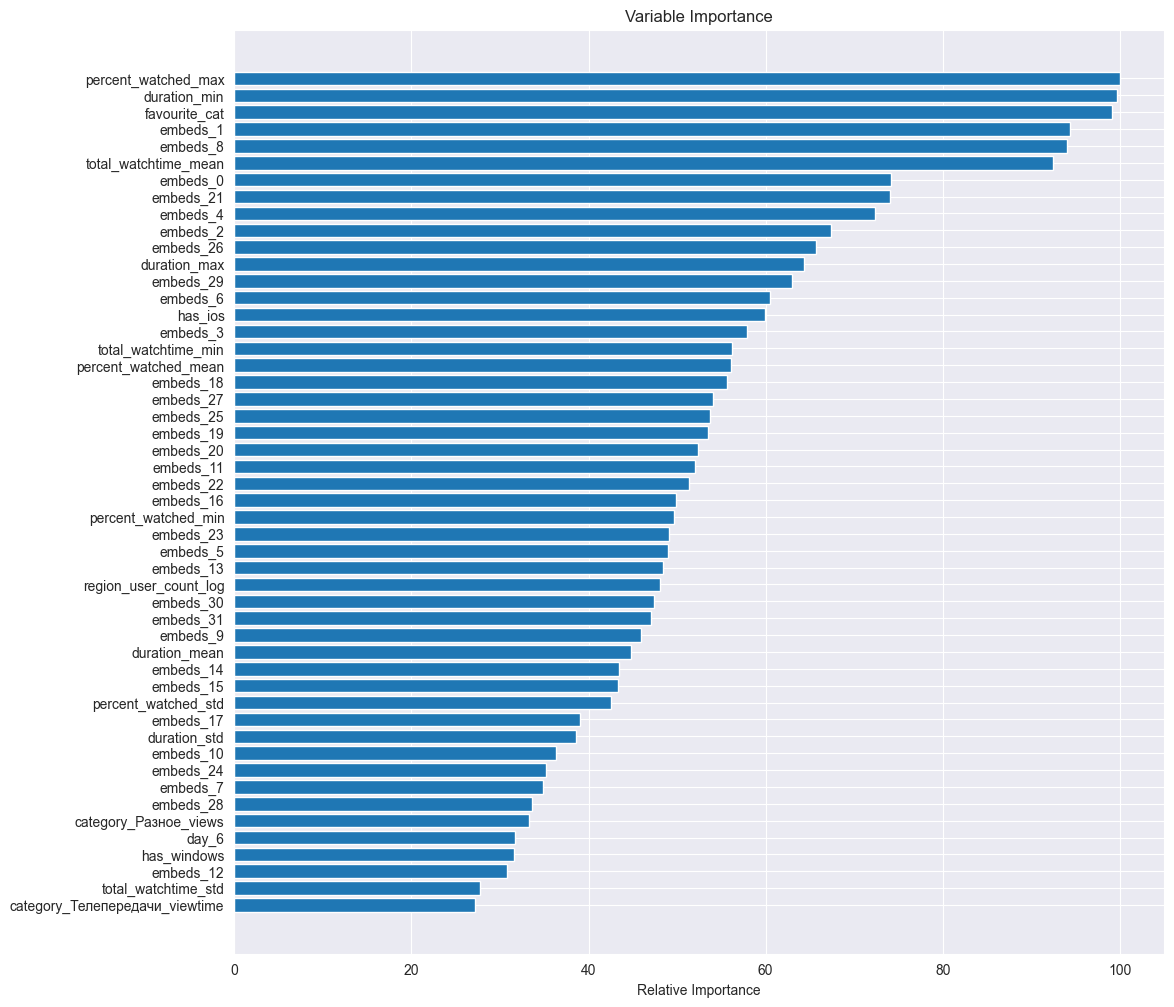

In [10]:
# Plot feature importances

def plot_importance(model, features, top=50):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 12))
    plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
    plt.yticks(pos[-top:], np.array(features.columns)[sorted_idx][-top:])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
plot_importance(catboost_age.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))

In [28]:
def objective_sex(trial):
    params = {
        'iterations': 1500,  # trial.suggest_int('iterations', 300, 1200),
        'depth': trial.suggest_int('depth', 5, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 10., log=True),
        'random_seed': 42,
        'verbose': 500,
    }

    catboost_sex = CatboostEstimator()
    
    features_to_drop = [
        'viewer_uid',
        'age'
    ]
    
    target_sex = 'sex'
    target_age = 'age_class'

    print('Sex model\n')
    
    score = catboost_sex.fit(
        X=features.drop(columns=features_to_drop + [target_sex] + [target_age]),
        y=features[target_sex],
        n_splits=2,
        cat_features=cat_features,
        score=score_sex,
        catboost_params=params,
    )
    
    return score

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_sex, n_trials=20)



[I 2024-09-28 22:31:34,416] A new study created in memory with name: no-name-4bbd980d-abfe-4424-8346-e9b9c786a3fb


Sex model

0:	learn: 0.6931440	test: 0.6931440	best: 0.6931440 (0)	total: 375ms	remaining: 3m 44s
500:	learn: 0.6915582	test: 0.6915562	best: 0.6915562 (500)	total: 55.5s	remaining: 11s
599:	learn: 0.6912467	test: 0.6912442	best: 0.6912442 (599)	total: 1m 13s	remaining: 0us

bestTest = 0.6912441796
bestIteration = 599

model 0: score = 0.7303
0:	learn: 0.6931437	test: 0.6931438	best: 0.6931438 (0)	total: 151ms	remaining: 1m 30s
500:	learn: 0.6914915	test: 0.6915353	best: 0.6915353 (500)	total: 1m 18s	remaining: 15.5s
599:	learn: 0.6911659	test: 0.6912184	best: 0.6912184 (599)	total: 1m 32s	remaining: 0us

bestTest = 0.6912184333
bestIteration = 599

model 1: score = 0.7272
mean score = 0.7288, std = 0.0016
overall score = 0.7272


[I 2024-09-28 22:34:22,605] Trial 0 finished with value: 0.7272070750838833 and parameters: {'depth': 9, 'learning_rate': 1.0617534553816285e-05, 'l2_leaf_reg': 6.410545173925502}. Best is trial 0 with value: 0.7272070750838833.


Sex model

0:	learn: 0.6931309	test: 0.6931308	best: 0.6931308 (0)	total: 129ms	remaining: 1m 17s
500:	learn: 0.6849772	test: 0.6849165	best: 0.6849165 (500)	total: 54.4s	remaining: 10.7s
599:	learn: 0.6834164	test: 0.6833436	best: 0.6833436 (599)	total: 1m 5s	remaining: 0us

bestTest = 0.6833436031
bestIteration = 599

model 0: score = 0.7296
0:	learn: 0.6931289	test: 0.6931294	best: 0.6931294 (0)	total: 106ms	remaining: 1m 3s
500:	learn: 0.6846415	test: 0.6848239	best: 0.6848239 (500)	total: 59.4s	remaining: 11.7s


[I 2024-09-28 22:36:36,094] Trial 1 finished with value: 0.7244628135902051 and parameters: {'depth': 8, 'learning_rate': 5.793824848679666e-05, 'l2_leaf_reg': 2.666093979006269}. Best is trial 0 with value: 0.7272070750838833.


599:	learn: 0.6830108	test: 0.6832301	best: 0.6832301 (599)	total: 1m 6s	remaining: 0us

bestTest = 0.6832301436
bestIteration = 599

model 1: score = 0.7245
mean score = 0.7271, std = 0.0026
overall score = 0.7245
Sex model

0:	learn: 0.6929943	test: 0.6929920	best: 0.6929920 (0)	total: 47.7ms	remaining: 28.6s
500:	learn: 0.6327215	test: 0.6317567	best: 0.6317567 (500)	total: 22.4s	remaining: 4.42s
599:	learn: 0.6244001	test: 0.6232869	best: 0.6232869 (599)	total: 26.9s	remaining: 0us

bestTest = 0.6232868628
bestIteration = 599

model 0: score = 0.727
0:	learn: 0.6929790	test: 0.6929835	best: 0.6929835 (0)	total: 59.2ms	remaining: 35.5s
500:	learn: 0.6302562	test: 0.6314372	best: 0.6314372 (500)	total: 24.1s	remaining: 4.76s


[I 2024-09-28 22:37:35,606] Trial 2 finished with value: 0.7233628869186499 and parameters: {'depth': 6, 'learning_rate': 0.0006011592496820577, 'l2_leaf_reg': 6.353170939902323}. Best is trial 0 with value: 0.7272070750838833.


599:	learn: 0.6216614	test: 0.6230534	best: 0.6230534 (599)	total: 31.5s	remaining: 0us

bestTest = 0.6230533694
bestIteration = 599

model 1: score = 0.7234
mean score = 0.7252, std = 0.0018
overall score = 0.7234
Sex model

0:	learn: 0.6931418	test: 0.6931417	best: 0.6931417 (0)	total: 92.1ms	remaining: 55.2s


[W 2024-09-28 22:38:02,671] Trial 3 failed with parameters: {'depth': 8, 'learning_rate': 1.9328411148055233e-05, 'l2_leaf_reg': 7.498903727374464} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/Users/p.a.nikulin/ML/SocDemPrediction/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/hq/yj5qdgb5077ghh_rn57wllc80000gq/T/ipykernel_12687/2847862197.py", line 22, in objective_sex
    score = catboost_sex.fit(
            ^^^^^^^^^^^^^^^^^
  File "/var/folders/hq/yj5qdgb5077ghh_rn57wllc80000gq/T/ipykernel_12687/3488898636.py", line 21, in fit
    model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
  File "/Users/p.a.nikulin/ML/SocDemPrediction/.venv/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_we

KeyboardInterrupt: 

In [ ]:
def objective_age(trial):
    params = {
        'iterations': 1500,  # trial.suggest_int('iterations', 300, 1200),
        'depth': trial.suggest_int('depth', 5, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5, 10., log=True),
        'random_seed': 42,
        'verbose': 500,
    }

    print('\n\n\nAge model\n')
    
    catboost_age = CatboostEstimator()

    features_to_drop = [
        'viewer_uid',
        'age'
    ]

    target_sex = 'sex'
    target_age = 'age_class'

    print('Age model\n')

    score = catboost_age.fit(
        X=features.drop(columns=features_to_drop + [target_sex] + [target_age]),
        y=features[target_age],
        n_splits=2,
        cat_features=cat_features,
        score=score_age,
        catboost_params=params,
    )

    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_age, n_trials=20)
